# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Признаки**
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

**Целевой признак** 
* Exited — факт ухода клиента

## Подготовка данных

In [1]:
import pandas as pd # импорт библиотеки pandas
pd.set_option('display.float_format', '{:,.2f}'.format) # убираем экспонентациальные формы
import warnings
warnings.simplefilter('ignore')
from scipy import stats as st
pd.set_option('display.max_columns', None)
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from catboost import Pool, cv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import svm, datasets
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy.stats import uniform
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
df = pd.read_csv('Churn.csv', index_col='RowNumber')# чтение файла с данными и сохранение в df

In [3]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88",1
2,15647311,Hill,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58",0
3,15619304,Onio,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57",1
4,15701354,Boni,699,France,Female,39,1.00,0.00,2,0,0,"93,826.63",0
5,15737888,Mitchell,850,Spain,Female,43,2.00,"125,510.82",1,1,1,"79,084.10",0


In [4]:
# Приводим все названия колонок к нижнему регистру
df.columns = df.columns.str.lower()
df.columns

Index(['customerid', 'surname', 'creditscore', 'geography', 'gender', 'age',
       'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember',
       'estimatedsalary', 'exited'],
      dtype='object')

In [5]:
df.columns = ['customer_id', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_crcard',
       'isactive_member', 'estimated_salary', 'exited']
df.columns

Index(['customer_id', 'surname', 'creditscore', 'geography', 'gender', 'age',
       'tenure', 'balance', 'num_of_products', 'has_crcard', 'isactive_member',
       'estimated_salary', 'exited'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   surname           10000 non-null  object 
 2   creditscore       10000 non-null  int64  
 3   geography         10000 non-null  object 
 4   gender            10000 non-null  object 
 5   age               10000 non-null  int64  
 6   tenure            9091 non-null   float64
 7   balance           10000 non-null  float64
 8   num_of_products   10000 non-null  int64  
 9   has_crcard        10000 non-null  int64  
 10  isactive_member   10000 non-null  int64  
 11  estimated_salary  10000 non-null  float64
 12  exited            10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


In [7]:
# проверяем пропуски
df[df['tenure'].isnull() == True].head(15)

,customer_id,surname,creditscore,geography,gender,age,tenure,balance,num_of_products,has_crcard,isactive_member,estimated_salary,exited
RowNumber,,,,,,,,,,,,,
31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,"140,469.38",1
49,15766205,Yin,550,Germany,Male,38,NaN,"103,391.38",1,0,1,"90,878.13",0
52,15768193,Trevisani,585,Germany,Male,36,NaN,"146,050.97",2,0,0,"86,424.57",0
54,15702298,Parkhill,655,Germany,Male,41,NaN,"125,561.97",1,0,0,"164,040.94",1
61,15651280,Hunter,742,Germany,Male,35,NaN,"136,857.00",1,0,0,"84,509.57",0
83,15641732,Mills,543,France,Female,36,NaN,0.00,2,0,0,"26,019.59",0
86,15805254,Ndukaku,652,Spain,Female,75,NaN,0.00,2,1,1,"114,675.75",0
95,15676966,Capon,730,Spain,Male,42,NaN,0.00,2,0,1,"85,982.47",0
100,15633059,Fanucci,413,France,Male,34,NaN,0.00,2,0,0,"6,534.18",0


In [8]:
df['tenure'].value_counts().to_frame()

,tenure
1.00,952
2.00,950
8.00,933
3.00,928
5.00,927
7.00,925
4.00,885
9.00,882
6.00,881
10.00,446


In [9]:
df['tenure'].isna().sum()

909

При анализе данных столбца 'tenure' выявлено большое отклонение в количестве новых клиентов банка, которые пользуются его услугами менее года, по сравнению с другими. Делаем вывод что пропуски в данном столбце связаны с новыми клиентами банка.

In [10]:
# Заполняем пропуски нулями
df['tenure'] = df['tenure'].fillna(0)

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,"10,000.00","15,690,940.57","71,936.19","15,565,701.00","15,628,528.25","15,690,738.00","15,753,233.75","15,815,690.00"
creditscore,"10,000.00",650.53,96.65,350.00,584.00,652.00,718.00,850.00
age,"10,000.00",38.92,10.49,18.00,32.00,37.00,44.00,92.00
tenure,"10,000.00",4.54,3.11,0.00,2.00,4.00,7.00,10.00
balance,"10,000.00","76,485.89","62,397.41",0.00,0.00,"97,198.54","127,644.24","250,898.09"
num_of_products,"10,000.00",1.53,0.58,1.00,1.00,1.00,2.00,4.00
has_crcard,"10,000.00",0.71,0.46,0.00,0.00,1.00,1.00,1.00
isactive_member,"10,000.00",0.52,0.50,0.00,0.00,1.00,1.00,1.00
estimated_salary,"10,000.00","100,090.24","57,510.49",11.58,"51,002.11","100,193.91","149,388.25","199,992.48"
exited,"10,000.00",0.20,0.40,0.00,0.00,0.00,0.00,1.00


In [12]:
df['exited'].value_counts().to_frame()

,exited
0,7963
1,2037


In [13]:
df.duplicated().sum()

0

In [14]:
# удаляем лишние столбцы данных и  перезапись таблицы
data = df.drop(['customer_id', 'surname'], axis=1).copy()
data.head()

,creditscore,geography,gender,age,tenure,balance,num_of_products,has_crcard,isactive_member,estimated_salary,exited
RowNumber,,,,,,,,,,,
1,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88",1
2,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58",0
3,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57",1
4,699,France,Female,39,1.00,0.00,2,0,0,"93,826.63",0
5,850,Spain,Female,43,2.00,"125,510.82",1,1,1,"79,084.10",0


In [15]:
data['geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

In [16]:
data['gender'].value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

In [17]:
# Преобразовываем категориальные признаки в численные
gender_ohe = pd.get_dummies(df["gender"], drop_first=True)
country_ohe = pd.get_dummies(df["geography"], drop_first=True)

data.drop(["gender", "geography"], axis=1, inplace=True)

df_ohe = pd.concat([data, gender_ohe, country_ohe], axis=1)

df_ohe.head()

,creditscore,age,tenure,balance,num_of_products,has_crcard,isactive_member,estimated_salary,exited,Male,Germany,Spain
RowNumber,,,,,,,,,,,,
1,619,42,2.00,0.00,1,1,1,"101,348.88",1,0,0,0
2,608,41,1.00,"83,807.86",1,0,1,"112,542.58",0,0,0,1
3,502,42,8.00,"159,660.80",3,1,0,"113,931.57",1,0,0,0
4,699,39,1.00,0.00,2,0,0,"93,826.63",0,0,0,0
5,850,43,2.00,"125,510.82",1,1,1,"79,084.10",0,0,0,1


In [18]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   creditscore       10000 non-null  int64  
 1   age               10000 non-null  int64  
 2   tenure            10000 non-null  float64
 3   balance           10000 non-null  float64
 4   num_of_products   10000 non-null  int64  
 5   has_crcard        10000 non-null  int64  
 6   isactive_member   10000 non-null  int64  
 7   estimated_salary  10000 non-null  float64
 8   exited            10000 non-null  int64  
 9   Male              10000 non-null  uint8  
 10  Germany           10000 non-null  uint8  
 11  Spain             10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 810.5 KB


In [19]:
# проводим стандартизацию данных
numeric = ['creditscore', 'age', 'balance', 'estimated_salary']
scaler = StandardScaler()
scaler.fit(df_ohe[numeric])
pd.options.mode.chained_assignment = None
df_ohe[numeric] = scaler.transform(df_ohe[numeric])
df_ohe.head()

,creditscore,age,tenure,balance,num_of_products,has_crcard,isactive_member,estimated_salary,exited,Male,Germany,Spain
RowNumber,,,,,,,,,,,,
1,-0.33,0.29,2.00,-1.23,1,1,1,0.02,1,0,0,0
2,-0.44,0.20,1.00,0.12,1,0,1,0.22,0,0,0,1
3,-1.54,0.29,8.00,1.33,3,1,0,0.24,1,0,0,0
4,0.50,0.01,1.00,-1.23,2,0,0,-0.11,0,0,0,0
5,2.06,0.39,2.00,0.79,1,1,1,-0.37,0,0,0,1


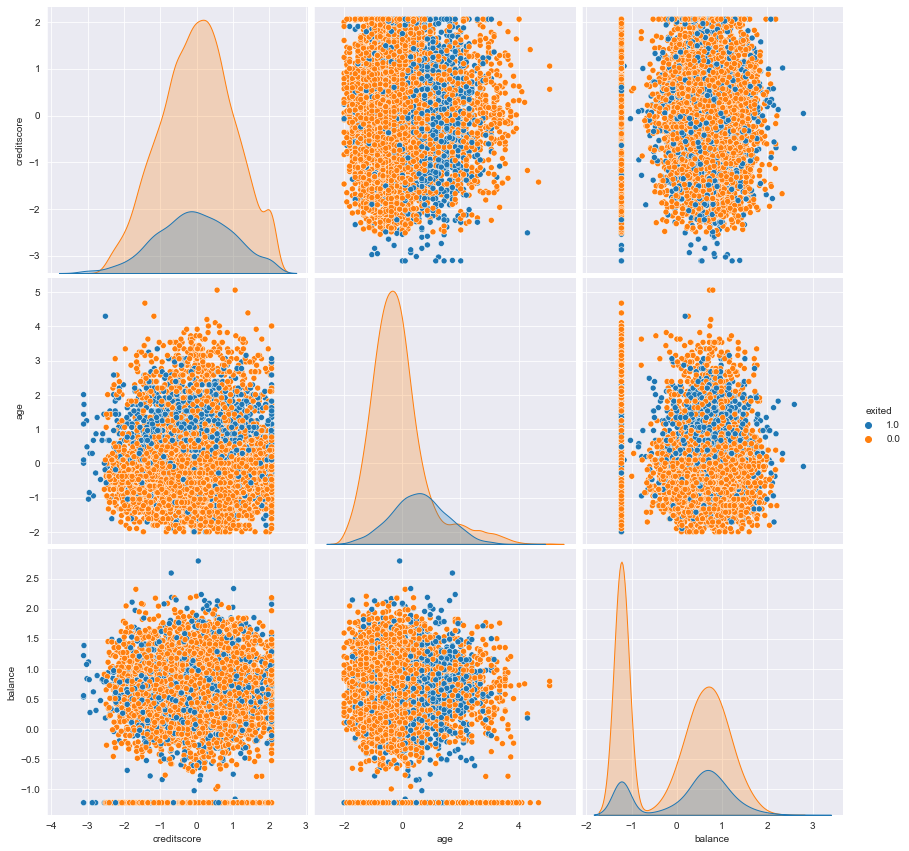

In [20]:
sns.pairplot(df_ohe,
             vars = ['creditscore', 'age', 'balance'],
             hue ='exited',
             hue_order = [1.0, 0.0],
             height = 4)

### Вывод:
При проверке данных выявлены и устранены следующие недостатки:
* Привели все названия столбцов к нижнему регистру и корректному написанию
* Заполнили пропуски в столбце "tenure" нулями, исходя из предположения, что если данные отсутствуют то данный человек является новым клиентом банка
* Удалили лишние столбцы 'row_number', 'customer_id', 'surname'
* Провели стандартизацию данных

## Исследование задачи

In [21]:
features = df_ohe.drop(['exited'], axis=1) # данные с признаками
target = df_ohe['exited'] # данные с целевым признаком

In [22]:
# разделяем исходные данные на обучающую, валидационную и тестовую выборки
features_train, features2, target_train, target2 = train_test_split(
    features, target, test_size=0.4, random_state=12345)

In [23]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features2, target2, test_size=0.5, random_state=12345)

In [24]:
# Проверяем количество строк в тренировочной, тестовой и валидационной выборке
print('Тренировочная выборка:', len(features_train))
print('Валидационная выборка:', len(features_valid))
print('Тестовая выборка:', len(features_test))
print('Общее количество:', len(df_ohe))

Тренировочная выборка: 6000
Валидационная выборка: 2000
Тестовая выборка: 2000
Общее количество: 10000


In [25]:
df['exited'].value_counts().to_frame()

,exited
0,7963
1,2037


In [26]:
lregress1 = LogisticRegression()
lregress1.fit(features_train, target_train.ravel())
prediction = lregress1.predict(features_test)
print(classification_report(target_test, prediction))

              precision    recall  f1-score   support

           0       0.81      0.95      0.88      1577
           1       0.52      0.19      0.27       423

    accuracy                           0.79      2000
   macro avg       0.67      0.57      0.58      2000
weighted avg       0.75      0.79      0.75      2000



Точность модели 79%. Колонка «recall» показывает меру полноты классификатора, способность классификатора правильно находить все положительные экземпляры. Из неё видно, что отзыв миноритарного класса гораздо меньше, то есть модель более склонна к классу большинства.

In [27]:
# обучаем и проверяем модель
best_model = None
best_est = 0
best_result = 0
for est in range(1, 31):
    model = RandomForestClassifier(random_state=12345, n_estimators=est) # обучаем модель
    model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)    
    if result > best_result:
        best_model = model # сохраните наилучшую модель
        best_est = est # значение n_estimators
        best_result = result #  сохраните наилучшее значение

print("F1 наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est)

F1 наилучшей модели на валидационной выборке: 0.5884016973125884 Количество деревьев: 13


In [28]:
# обучаем и проверяем модель
model = LogisticRegression(solver='liblinear', random_state=12345) # обучаем модель
model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.33389544688026984


In [29]:
# обучаем и проверяем модель
best_model = None
best_est = 0
best_result = 0
for est in range(1, 31):
    model = DecisionTreeClassifier(random_state=12345, max_depth=est) # обучаем модель
    model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)    
    if result > best_result:
        best_model = model # сохраните наилучшую модель
        best_est = est 
        best_result = result #  сохраните наилучшее значение

print("F1 наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est)

F1 наилучшей модели на валидационной выборке: 0.5746164574616458 Количество деревьев: 9


In [30]:
# обучаем и проверяем модель
model = CatBoostClassifier(verbose=100, random_state=12345) # обучаем модель
model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

Learning rate set to 0.022141
0:	learn: 0.6746593	total: 166ms	remaining: 2m 46s
100:	learn: 0.3278719	total: 435ms	remaining: 3.87s
200:	learn: 0.3042179	total: 708ms	remaining: 2.82s
300:	learn: 0.2902686	total: 1.03s	remaining: 2.4s
400:	learn: 0.2776218	total: 1.36s	remaining: 2.03s
500:	learn: 0.2666749	total: 1.66s	remaining: 1.65s
600:	learn: 0.2555140	total: 1.97s	remaining: 1.31s
700:	learn: 0.2455861	total: 2.29s	remaining: 975ms
800:	learn: 0.2359822	total: 2.57s	remaining: 638ms
900:	learn: 0.2278128	total: 2.85s	remaining: 313ms
999:	learn: 0.2204560	total: 3.21s	remaining: 0us
F1: 0.6032210834553441


### Вывод:
* Нами удалены ненужные функции - такие как фамилия, идентификатор клиента и номер строки
* проведено кодирование категориальных переменных
* проведено масштабирование количественных переменных
* разделены выборки в соотношении 60%: 20%: 20% - обучающую, валидационную и тестовую
* Мы попытались обучить модели на объектах с дисбалансом классов. Теперь давайте попробуем избавиться от этой проблемы, выбрав гиперпараметры модели.

## Борьба с дисбалансом

In [31]:
# Создаем новую обучающую выборку
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled = shuffle(features_upsampled, random_state=12345)
    target_upsampled = shuffle(target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

    
    
features_upsampled, target_upsampled = upsample(features_train, target_train, 5)

print(features_upsampled.shape)
print(target_upsampled.shape)

(10784, 11)
(10784,)


In [32]:
# обучаем и проверяем модель
best_model = None
best_est = 0
best_result = 0
for est in range(1, 31):
    model = RandomForestClassifier(random_state=12345, n_estimators=est) # обучаем модель
    model.fit(features_upsampled, target_upsampled) # обучаем модель на тренировочной выборке
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)    
    if result > best_result:
        best_model = model # сохраните наилучшую модель
        best_est = est # значение n_estimators
        best_result = result #  сохраните наилучшее значение метрики accuracy на валидационных данных

print("F1 наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est)

F1 наилучшей модели на валидационной выборке: 0.6082603254067585 Количество деревьев: 9


In [33]:
# обучаем и проверяем модель
model = LogisticRegression(solver='liblinear', random_state=12345) # обучаем модель
model.fit(features_upsampled, target_upsampled) # обучаем модель на тренировочной выборке
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.48360030511060265


In [34]:
# обучаем и проверяем модель
best_model = None
best_est = 0
best_result = 0
for est in range(1, 31):
    model = DecisionTreeClassifier(random_state=12345, max_depth=est) # обучаем модель
    model.fit(features_upsampled, target_upsampled) # обучаем модель на тренировочной выборке
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)    
    if result > best_result:
        best_model = model # сохраните наилучшую модель
        best_est = est # значение n_estimators
        best_result = result #  сохраните наилучшее значение

print("F1 наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est)

F1 наилучшей модели на валидационной выборке: 0.558282208588957 Количество деревьев: 3


In [35]:
# обучаем и проверяем модель
model = CatBoostClassifier(verbose=100, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

Learning rate set to 0.02844
0:	learn: 0.6767914	total: 5.35ms	remaining: 5.35s
100:	learn: 0.4224763	total: 523ms	remaining: 4.65s
200:	learn: 0.3848347	total: 1.1s	remaining: 4.39s
300:	learn: 0.3565016	total: 1.64s	remaining: 3.81s
400:	learn: 0.3315195	total: 2.25s	remaining: 3.36s
500:	learn: 0.3097997	total: 2.78s	remaining: 2.77s
600:	learn: 0.2918026	total: 3.3s	remaining: 2.19s
700:	learn: 0.2739337	total: 3.83s	remaining: 1.63s
800:	learn: 0.2581360	total: 4.36s	remaining: 1.08s
900:	learn: 0.2440132	total: 4.88s	remaining: 536ms
999:	learn: 0.2308356	total: 5.38s	remaining: 0us
F1: 0.6105476673427992


In [36]:
# Создаем новую обучающую выборку
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_sample = features_zeros.sample(frac=0.1, random_state=12345)
    target_sample = target_zeros.sample(frac=0.1, random_state=12345)
    
    features_downsampled = pd.concat([features_sample] + [features_ones])
    target_downsampled = pd.concat([target_sample] + [target_ones])
    
    features_downsampled = shuffle(features_downsampled, random_state=12345)
    target_downsampled = shuffle(target_downsampled, random_state=12345)
        
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

print(features_downsampled.shape)
print(target_downsampled.shape)

(1676, 11)
(1676,)


In [37]:
# обучаем и проверяем модель 
best_model = None
best_est = 0
best_result = 0
for est in range(1, 31):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, class_weight='balanced') # обучаем модель
    model.fit(features_downsampled, target_downsampled) # обучаем модель на выборке
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)    
    if result > best_result:
        best_model = model # сохраните наилучшую модель
        best_est = est # значение n_estimators
        best_result = result #  сохраните наилучшее значение метрики accuracy на валидационных данных

print("F1 наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est)

F1 наилучшей модели на валидационной выборке: 0.492526690391459 Количество деревьев: 6


In [38]:
# обучаем и проверяем модель 
model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=12345) # обучаем модель
model.fit(features_downsampled, target_downsampled) # обучаем модель на выборке
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.4795918367346939


In [39]:
# обучаем и проверяем модель
best_model = None
best_est = 0
best_result = 0
for est in range(1, 31):
    model = DecisionTreeClassifier(random_state=12345, max_depth=est) # обучаем модель
    model.fit(features_downsampled, target_downsampled) # обучаем модель на выборке
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_model = model # сохраните наилучшую модель
        best_est = est 
        best_result = result #  сохраните наилучшее значение метрики accuracy на валидационных данных

print("F1 наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est)

F1 наилучшей модели на валидационной выборке: 0.49715909090909094 Количество деревьев: 6


In [40]:
# обучаем и проверяем модель 
model = CatBoostClassifier(verbose=100, random_state=12345) # обучаем модель
model.fit(features_downsampled, target_downsampled) # обучаем модель на выборке
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

Learning rate set to 0.012844
0:	learn: 0.6857973	total: 2.5ms	remaining: 2.5s
100:	learn: 0.4200704	total: 189ms	remaining: 1.68s
200:	learn: 0.3693443	total: 361ms	remaining: 1.43s
300:	learn: 0.3391845	total: 522ms	remaining: 1.21s
400:	learn: 0.3171778	total: 680ms	remaining: 1.01s
500:	learn: 0.2978219	total: 846ms	remaining: 842ms
600:	learn: 0.2807608	total: 1.03s	remaining: 681ms
700:	learn: 0.2654164	total: 1.24s	remaining: 531ms
800:	learn: 0.2516032	total: 1.45s	remaining: 359ms
900:	learn: 0.2370902	total: 1.65s	remaining: 182ms
999:	learn: 0.2233910	total: 1.83s	remaining: 0us
F1: 0.4926958831341302


In [41]:
# Ищим оптимальные гиперпараметры модели
par_grid_ensemble = {'n_estimators': [3, 5, 10, 30],
                     'criterion': ['gini', 'entropy'],
                     'min_samples_split': range(5, 15)
                    }
model = RandomForestClassifier(random_state=12345)

grid_search = GridSearchCV(model, par_grid_ensemble, cv=5,
                           scoring='accuracy'
                          )
grid_search.fit(features_upsampled, target_upsampled)
grid_search.best_params_

{'criterion': 'gini', 'min_samples_split': 5, 'n_estimators': 30}

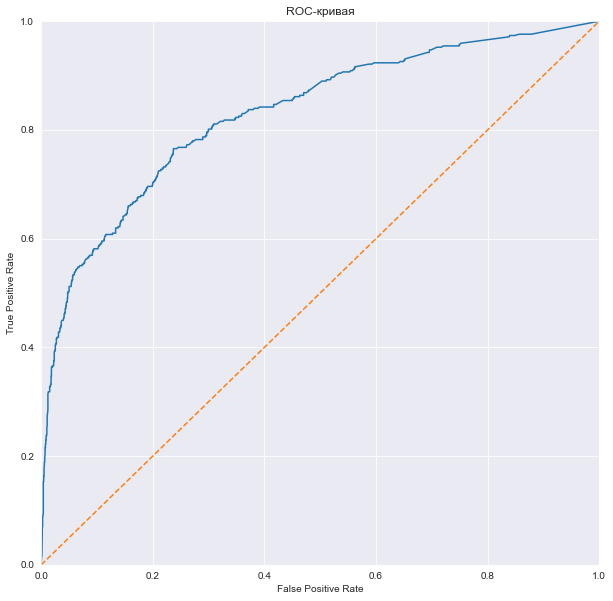

AUC: 0.8300013912496447
F1: 0.6020671834625323


In [42]:
# Измеряем AUC-ROC и F1-меру
model_rfc = RandomForestClassifier(criterion='gini', min_samples_split=5,
                               n_estimators=30, random_state=12345,)
model_rfc.fit(features_upsampled, target_upsampled)
predicted_valid = model_rfc.predict(features_valid)

probabilities_valid_rfc = model_rfc.predict_proba(features_valid)
probabilities_one_valid_rfc = probabilities_valid_rfc[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_rfc) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score (target_valid, probabilities_one_valid_rfc)

print("AUC:", auc_roc)
print("F1:", f1_score(target_valid, predicted_valid))

In [43]:
# Ищим оптимальные гиперпараметры модели
par_grid_logist = {'intercept_scaling': [0.5, 1.0, 1.5],
                   'class_weight': [None, 'balanced'],
                   'C': [0.5, 1, 1.5]
                   }
model = LogisticRegression(solver='liblinear',random_state=12345)

grid_search = GridSearchCV(model, par_grid_logist, cv=5,
                           scoring='f1')
grid_search.fit(features_upsampled, target_upsampled)
grid_search.best_params_

{'C': 0.5, 'class_weight': None, 'intercept_scaling': 1.0}

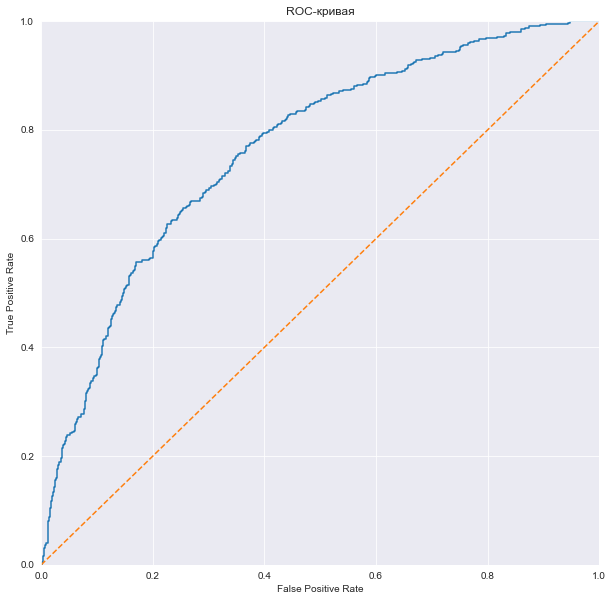

AUC: 0.7640954760190904
F1: 0.483969465648855


In [44]:
# Измеряем AUC-ROC и F1-меру
model_lr = LogisticRegression(C=0.5, class_weight=None, intercept_scaling=1,
                                solver='liblinear', random_state=12345)
model_lr.fit(features_upsampled, target_upsampled)
predicted_valid = model_lr.predict(features_valid)

probabilities_valid_lr = model_lr.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_lr) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

auc_roc = roc_auc_score (target_valid, probabilities_one_valid_lr)

print("AUC:", auc_roc)
print("F1:", f1_score(target_valid, predicted_valid))

In [45]:
# Ищим оптимальные гиперпараметры модели
par_grid_ensemble = {'criterion': ['gini', 'entropy'],
                     'max_depth' : range(5, 21),
                     'min_samples_split': range(5, 15)
                    }
model = DecisionTreeClassifier(random_state=12345)

grid_search = GridSearchCV(model, par_grid_ensemble, cv=5,
                           scoring='accuracy'
                          )
grid_search.fit(features_upsampled, target_upsampled)
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 5}

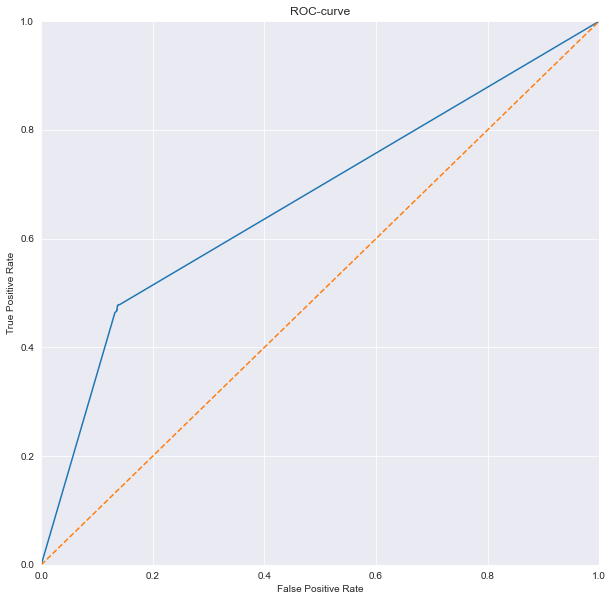

AUC: 0.6700228043963489
F1: 0.4784688995215311


In [46]:
# Измеряем AUC-ROC и F1-меру
model_dtc = DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=5, random_state=12345)

model_dtc.fit(features_upsampled, target_upsampled)

predicted_valid = model_dtc.predict(features_valid)

probabilities_valid_dtc = model_dtc.predict_proba(features_valid)
probabilities_one_valid_dtc = probabilities_valid_dtc[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_dtc) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

auc_roc = roc_auc_score (target_valid, probabilities_one_valid_dtc)

print("AUC:", auc_roc)
print("F1:", f1_score(target_valid, predicted_valid))

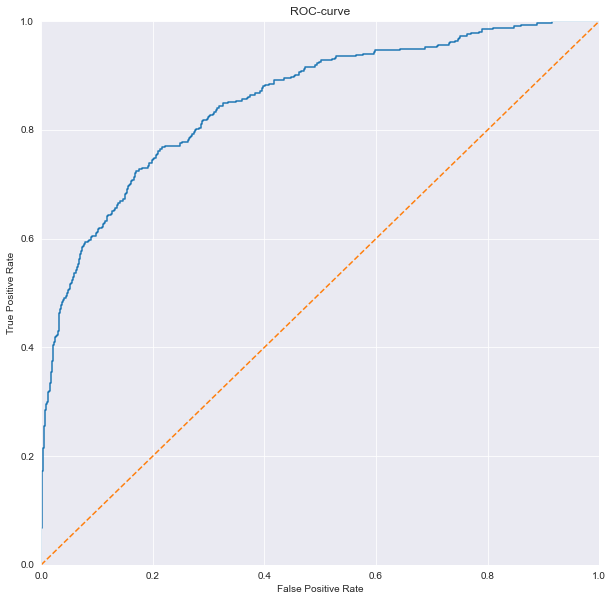

AUC: 0.8537176610069017
F1: 0.6105476673427992


In [47]:
# Измеряем AUC-ROC и F1-меру
model_cbc = CatBoostClassifier(custom_loss=['F1'], logging_level='Silent', random_seed=12345)
model_cbc.fit(features_upsampled, target_upsampled)
predicted_valid = model_cbc.predict(features_valid)

probabilities_valid_cbc = model_cbc.predict_proba(features_valid)
probabilities_one_valid_cbc = probabilities_valid_cbc[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_cbc) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

auc_roc = roc_auc_score (target_valid, probabilities_one_valid_cbc)

print("AUC:", auc_roc)
print("F1:", f1_score(target_valid, predicted_valid))

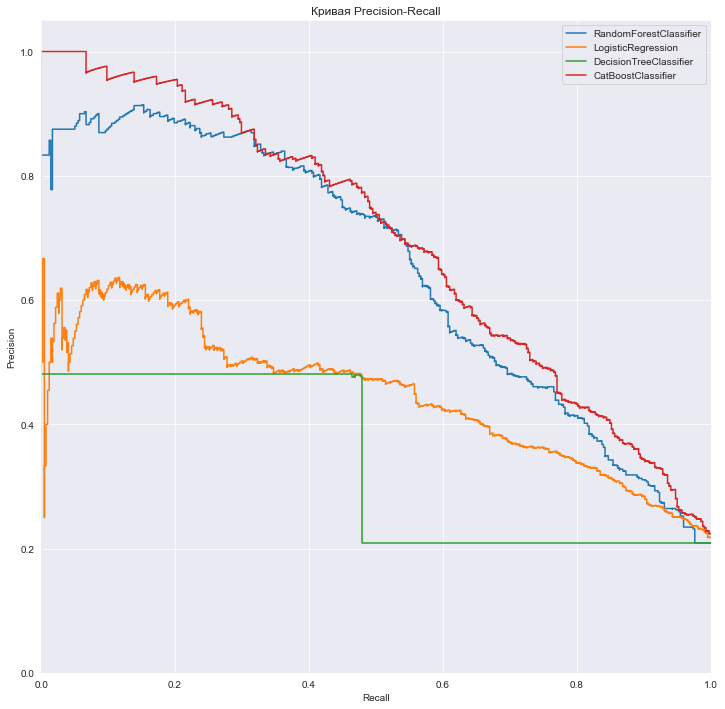

In [48]:
precision_rfc, recall_rfc, thresholds_rfc = precision_recall_curve(target_valid, probabilities_valid_rfc[:, 1])
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(target_valid, probabilities_valid_lr[:, 1])
precision_dtc, recall_dtc, thresholds_dtc = precision_recall_curve(target_valid, probabilities_valid_dtc[:, 1])
precision_cbc, recall_cbc, thresholds_cbc = precision_recall_curve(target_valid, probabilities_valid_cbc[:, 1])

plt.figure(figsize=(12, 12))
plt.step(recall_rfc, precision_rfc, where='post')
plt.step(recall_lr, precision_lr, where='post')
plt.step(recall_dtc, precision_dtc, where='post')
plt.step(recall_cbc, precision_cbc, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.legend(['RandomForestClassifier','LogisticRegression', 'DecisionTreeClassifier','CatBoostClassifier'])
plt.show() 

Мы построили объединенный график PR-кривых разных моделей. Из их характеристик известно, что чем выше кривая, тем лучше модель. Явными фаворитами являются модели RandomForestClassifier и CatBoostClassifier.

### Вывод: 
* Улучшили качество моделей, учитывая дисбаланс классов. 
* Обучили разные модели и нашли лучшие.

## Тестирование модели

In [49]:
# Строки для сбора данных о моделях

data_model = []
data_acc = []
data_f1 = []
data_auc = []

In [50]:
# Проводим тестирование модели и записываем данные тестирования
predictions_test = model_rfc.predict(features_test)
test_acc = accuracy_score(target_test, predictions_test)
test_f1 = f1_score(target_test, predictions_test)
test_auc = roc_auc_score (target_valid, probabilities_one_valid_rfc)

data_model.append('RandomForestClassifier')
data_acc.append(round(test_acc, 2))
data_f1.append(round(test_f1, 2))
data_auc.append(round(test_auc, 2))


print("accuracy:", test_acc)
print("F1-мера:", test_f1)
print("AUC:", test_auc)

accuracy: 0.8385
F1-мера: 0.5777777777777777
AUC: 0.8300013912496447


In [51]:
# Проводим тестирование модели и записываем данные тестирования
predictions_test = model_lr.predict(features_test)
test_acc = accuracy_score(target_test, predictions_test)
test_f1 = f1_score(target_test, predictions_test)
test_auc = roc_auc_score (target_valid, probabilities_one_valid_lr)

data_model.append('LogisticRegression')
data_acc.append(round(test_acc, 2))
data_f1.append(round(test_f1, 2))
data_auc.append(round(test_auc, 2))


print("accuracy:", test_acc)
print("F1-мера:", test_f1)
print("AUC:", test_auc)

accuracy: 0.664
F1-мера: 0.4862385321100917
AUC: 0.7640954760190904


In [52]:
# Проводим тестирование модели и записываем данные тестирования
predictions_test = model_dtc.predict(features_test)
test_acc = accuracy_score(target_test, predictions_test)
test_f1 = f1_score(target_test, predictions_test)
test_auc = roc_auc_score (target_valid, probabilities_one_valid_dtc)

data_model.append('DecisionTreeClassifier')
data_acc.append(round(test_acc, 2))
data_f1.append(round(test_f1, 2))
data_auc.append(round(test_auc, 2))


print("accuracy:", test_acc)
print("F1-мера:", test_f1)
print("AUC:", test_auc)

accuracy: 0.794
F1-мера: 0.5106888361045131
AUC: 0.6700228043963489


In [53]:
# Проводим тестирование модели и записываем данные тестирования
predictions_test = model_cbc.predict(features_test)
test_acc = accuracy_score(target_test, predictions_test)
test_f1 = f1_score(target_test, predictions_test)
test_auc = roc_auc_score (target_valid, probabilities_one_valid_cbc)

data_model.append('CatBoostClassifier')
data_acc.append(round(test_acc, 2))
data_f1.append(round(test_f1, 2))
data_auc.append(round(test_auc, 2))


print("accuracy:", test_acc)
print("F1-мера:", test_f1)
print("AUC:", test_auc)

accuracy: 0.8075
F1-мера: 0.6059365404298873
AUC: 0.8537176610069017


In [54]:
# Создаем таьлицу результатов
data_model = (pd.DataFrame({'Model':data_model, 'Accuracy':data_acc, 
                                'F1':data_f1, 'AUC':data_auc}).sort_values(by='F1', ascending=False).
                  reset_index(drop=True))

In [55]:
data_model['Результат тестирования'] = (
                   data_model['F1'].apply(lambda x: 'Хорошая модель' if x>0.59 else 'Плохая модель'))
data_model

,Model,Accuracy,F1,AUC,Результат тестирования
0,CatBoostClassifier,0.81,0.61,0.85,Хорошая модель
1,RandomForestClassifier,0.84,0.58,0.83,Плохая модель
2,DecisionTreeClassifier,0.79,0.51,0.67,Плохая модель
3,LogisticRegression,0.66,0.49,0.76,Плохая модель


In [56]:
# Проверяем модели на адекватность
strategies = ['most_frequent', 'prior', 'stratified', 'uniform', 'constant']
test_scores = []
for s in strategies:
    if s == 'constant':
        dclf = DummyClassifier(strategy = s, random_state = 12345, constant = 0)
    else:
        dclf = DummyClassifier(strategy = s, random_state = 12345)
    dclf.fit(features_train, target_train)
    score = dclf.score(features_test, target_test)
    print('Стратегия:', s, 'значение', score)

Стратегия: most_frequent значение 0.7885
Стратегия: prior значение 0.7885
Стратегия: stratified значение 0.6655
Стратегия: uniform значение 0.492
Стратегия: constant значение 0.7885


### Вывод:
* При финальном тестировании выявлена одна модель "CatBoostClassifier" удовлетворяющая условию задания, F1-мера которого составляет 0,60 